In [1]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import joblib

In [2]:
cwd       = os.getcwd()
file_path = r"Data\dataset_preprocessed.csv"

dataset   = os.path.join(cwd,file_path)

df_original = pd.read_csv(dataset)

In [3]:
df = df_original.copy()
df

,BIKE_STANDS,AVAILABLE_BIKE_STANDS,AVAILABLE_BIKES,LAT_SIN,LAT_COS,LON_SIN,LON_COS,STATUS_ENCODED,IS_WEEKEND,HOUR_SIN,HOUR_COS,MIN_SIN,MIN_COS,MONTH_SIN,MONTH_COS,DOW_SIN,DOW_COS
0,0.625000,0.775,0.000,0.802202,0.597053,-0.109084,0.994033,0,0,0.000000,1.000000,0.000000e+00,1.0,1.224647e-16,-1.0,0.433884,-0.900969
1,0.166667,0.250,0.250,0.802368,0.596830,-0.109182,0.994022,0,0,0.000000,1.000000,0.000000e+00,1.0,1.224647e-16,-1.0,0.433884,-0.900969
2,0.166667,0.350,0.150,0.802309,0.596908,-0.109211,0.994019,0,0,0.000000,1.000000,0.000000e+00,1.0,1.224647e-16,-1.0,0.433884,-0.900969
3,0.166667,0.150,0.350,0.802265,0.596969,-0.109266,0.994013,0,0,0.000000,1.000000,0.000000e+00,1.0,1.224647e-16,-1.0,0.433884,-0.900969
4,1.000000,0.150,0.850,0.802096,0.597195,-0.109043,0.994037,0,0,0.000000,1.000000,0.000000e+00,1.0,1.224647e-16,-1.0,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163585,1.000000,0.875,0.075,0.802178,0.597085,-0.108843,0.994059,0,0,-0.258819,0.965926,5.665539e-16,-1.0,1.224647e-16,-1.0,-0.433884,-0.900969
163586,1.000000,0.950,0.050,0.802127,0.597153,-0.108838,0.994059,0,0,-0.258819,0.965926,5.665539e-16,-1.0,1.224647e-16,-1.0,-0.433884,-0.900969
163587,0.583333,0.400,0.325,0.802347,0.596858,-0.108825,0.994061,0,0,-0.258819,0.965926,5.665539e-16,-1.0,1.224647e-16,-1.0,-0.433884,-0.900969
163588,0.583333,0.700,0.050,0.802346,0.596859,-0.109254,0.994014,0,0,-0.258819,0.965926,5.665539e-16,-1.0,1.224647e-16,-1.0,-0.433884,-0.900969


In [4]:
features = df.drop(["AVAILABLE_BIKES", "AVAILABLE_BIKE_STANDS"], axis=1)
labels = df["AVAILABLE_BIKES"]

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [5]:
def compare(model, features, labels,important_feaetures):
    model.fit(features, labels)
    y_pred_full = model.predict(x_test)
    mae_full = mean_absolute_error(y_test, y_pred_full)

    xgb_top = XGBRegressor(n_estimators=200, random_state=42)
    xgb_top.fit(features[important_feaetures], labels)   
    y_pred_top = xgb_top.predict(x_test[important_feaetures])
    mae_top = mean_absolute_error(y_test, y_pred_top)

    print(f"MAE with all features: {mae_full:.4f}")
    print(f"MAE with selected features: {mae_top:.4f}")

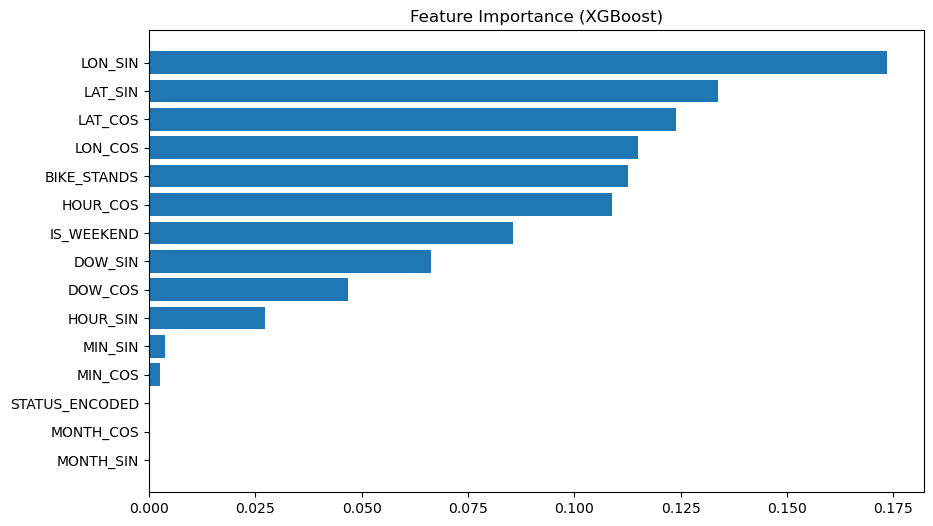

In [6]:
xgb_model = joblib.load("Outputs\Models\XG-Boost Model.joblib")

importances = xgb_model.feature_importances_
feature_names = x_train.columns

feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (XGBoost)")
plt.show()

top_features_importance = feat_imp_df['Feature'].head(10).tolist()


In [7]:
# Full feature model
xgb_full = XGBRegressor(n_estimators=200, random_state=42)
compare(model=xgb_model, features=x_train, labels=y_train, important_feaetures=top_features_importance)


MAE with all features: 0.1199
MAE with selected features: 0.1149


In [8]:
# Use XGBoost as the estimator for RFE
xgb_rfe_model = XGBRegressor(n_estimators=200, random_state=42)
rfe = RFE(estimator=xgb_rfe_model, n_features_to_select=10)
rfe.fit(x_train, y_train)

# Feature ranking
rfe_ranking = pd.DataFrame({
    "Feature": x_train.columns,
    "Ranking": rfe.ranking_
}).sort_values(by="Ranking")

print(rfe_ranking)

top_rfe_features = rfe_ranking[rfe_ranking['Ranking']==1]['Feature'].tolist()


           Feature  Ranking
0      BIKE_STANDS        1
1          LAT_SIN        1
3          LON_SIN        1
7         HOUR_SIN        1
6       IS_WEEKEND        1
13         DOW_SIN        1
9          MIN_SIN        1
8         HOUR_COS        1
14         DOW_COS        1
12       MONTH_COS        1
11       MONTH_SIN        2
10         MIN_COS        3
5   STATUS_ENCODED        4
4          LON_COS        5
2          LAT_COS        6


In [9]:
xgb_full = XGBRegressor(n_estimators=200, random_state=42)
compare(model=xgb_model, features=x_train, labels=y_train, important_feaetures=top_rfe_features)


MAE with all features: 0.1199
MAE with selected features: 0.1152
